# Simulation of Protein-Protein interactions

A step-by-step guide of how to perform a protein simulation with the software Faunus and Duello. 
Notebook created for the Young Researchers' Symposium III - Life Science.

Author: Isabel Vinterbladh, isabel.vinterbladh@compchem.lu.se

In [16]:
### Import all packages needed

import matplotlib.pyplot as plt
import os.path, os
from io import StringIO
from jinja2 import Template
import ruamel_yaml as yaml
import numpy as np
import json
import pandas as pd
import MDAnalysis as mda
import nglview as nv
import subprocess
%matplotlib inline

### Define the working directory and the Faunus directory

workdir = '/Users/isabelvinterbladh/Documents/YRI-Talk/YRI-Protein-Simulation' # Change to your working directory
faunusdir = '/Users/isabelvinterbladh/Documents/faunus' # Change to your Faunus directory or use faunusdir = os.getcwd() if you are in the Faunus from Conda


### Check what your working directory is (your current directory) by uncommenting
#!pwd
### Copy the output from this cell to the workdir definition above

### Go to the working directory
%cd $workdir

/Users/isabelvinterbladh/Documents/YRI-Talk/YRI-Protein-Simulation


## Faunus - a molecular simulation software

Faunus is a molecular simulation package for doing Metropolis Hastings Monte Carlo simulations of proteins, or other particles. Many different analysises, potentials and moves are implemented. To see all alternatives and read more about it, visit: https://faunus.readthedocs.io/en/latest/index.html

In [17]:
### Function creating input for simulation

def makeFaunusInput(outfile, **kwargs):
    ''' Generate faunus input file from Jinja2 template 
    Args:
        outfile (str): name of output file
        kwargs (dict): key-value pairs to be passed to the template 
    Example:
        makeFaunusInput('input.yml', Cs=0.1, pH=7, temp=298)
    '''
    with open('faunus_template.yml', 'r') as file: # this is the template file
        template = Template(file.read())
        Cs = kwargs['Cs']
        pH = kwargs['pH']
        dirname = f'Cs{Cs}pH{pH}'
        if not os.path.isdir(dirname):
            os.makedirs(dirname)
        with open(f'Cs{Cs}pH{pH}/' + outfile, 'w') as f:   # open a new faunus input file
            inputstr = template.render(kwargs)
            d = yaml.safe_load(StringIO(inputstr)) # convert string to stream
            f.write(yaml.dump(d))

In [18]:
### Define input parameters for simulation

salt_conc = 0.05                   # Salt concentration in Molar
pH = 7                             # pH of the solution
radius = 50                        # radius of cylinder box in Å
length = 100                       # length of cylinder box in Å   
insoffset = 30                     # Initial position of second protein, mass center separation in Å
steps_eq= 100                      # Number of equilibration steps for the simulation
steps_run = 5000                   # Number of production steps for the simulation
file = '../structures/2hiu.xyz'    # Structure file for the simulation

### Create input files for equilibration and production

makeFaunusInput('eq.yml', Cs = salt_conc, pH = pH, radius = radius, length = length, insoffset = insoffset, structure = file, micro = steps_eq)  # equilibration
makeFaunusInput('input.yml', Cs = salt_conc, pH = pH, radius = radius, length = length, insoffset = insoffset, structure = file, micro = steps_run) # production

In [19]:
### Function to run the simulation

def run_simulation(dir, runeq=True):
    """ Run a Faunus simulation in a given directory 
    Args:
        dir (str): directory where the input files are and the output will be saved
        runeq (bool): if True, run equilibration
    The Monte Carlo simulation is executed with Faunus and the output is saved in the directory.
    """
    %cd $workdir
    %cd $dir
    if runeq: 
        print('Running equilibration...')
        !yason.py eq.yml | faunus -v6 -o eqout.json > eq.log
    print('Running production...')
    !yason.py input.yml | faunus -v6 -s state.json > run.log

In [20]:
### Run the simulation

run_simulation(f'Cs{salt_conc}pH{pH}', True) #Args: Directory with input files; True/False if equilibration should be executed

/Users/isabelvinterbladh/Documents/YRI-Talk/YRI-Protein-Simulation
/Users/isabelvinterbladh/Documents/YRI-Talk/YRI-Protein-Simulation/Cs0.05pH7
Running equilibration...
[faunus 2766] I: reading atoms from external file '../structures/faunus-aminoacid-atoms.json'
[faunus 2766] T: creating exclusion matrix 0×0 for 0 atoms within distance 0
[faunus 2766] I: Reading molecule configuration from file: ../structures/2hiu.xyz
[faunus 2766] T: creating exclusion matrix 51×0 for 51 atoms within distance 0
[faunus 2766] T: creating exclusion matrix 0×0 for 0 atoms within distance 0
[faunus 2766] I: Reading molecule configuration from file: ../structures/2hiu.xyz
[faunus 2766] T: creating exclusion matrix 51×0 for 51 atoms within distance 0
[faunus 2766] T: space particle capacity = 102
[faunus 2766] T: space groups capacity = 2
[faunus 2766] I: adding 1 molecule1 molecules --> 2.11427E-03 mol/l (0 inactive)
[faunus 2766] I: adding 1 molecule2 molecules --> 2.11427E-03 mol/l (0 inactive)
[faunus 2

In [42]:
### Enter the directory with the simulation output

directoy = workdir + f'/Cs{salt_conc}pH{pH}'
%cd $directoy

/Users/isabelvinterbladh/Documents/YRI-Talk/YRI-Protein-Simulation/Cs0.05pH7


average charge = -1.24 (expecting -1.50)


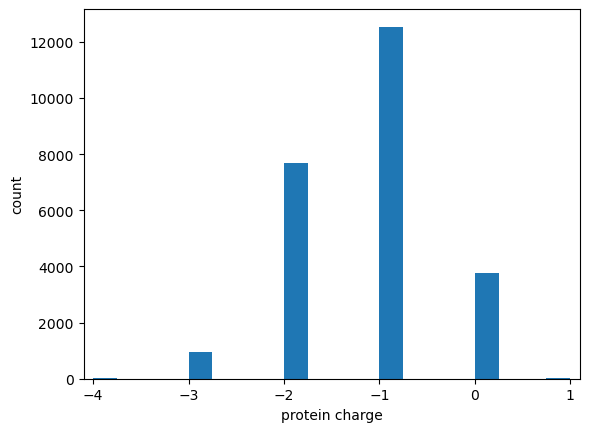

In [23]:
### Plotting the charge distribution of the protein during the simulation

step, q, avg = np.loadtxt('q.dat.gz', unpack=True)
qmin = q.min()
qmax = q.max()
plt.hist(q, bins=20)
plt.xlim(qmin-0.1,qmax+0.1)
plt.xlabel('protein charge')
plt.ylabel('count')
print("average charge = {:.2f} (expecting {:.2f})".format(q.mean(), 0.5*(qmax-qmin)+qmin ))

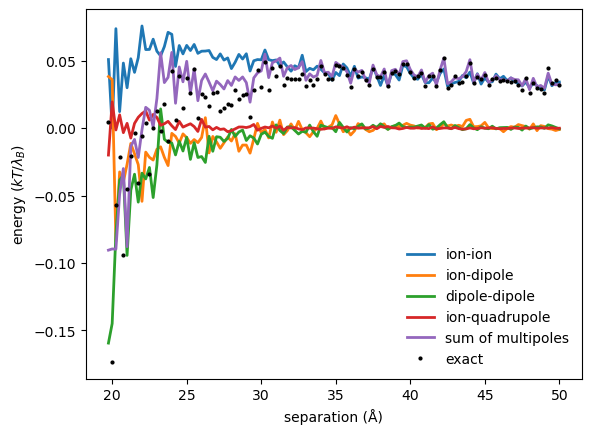

In [24]:
### Calculating the multipole moments

R, exact, total, ionion, iondip, dipdip, ionquad, mucorr = np.loadtxt('multipole.dat', unpack=True, skiprows=2)
lw=2
plt.plot(R, ionion, label='ion-ion', lw=lw)
plt.plot(R, iondip, label='ion-dipole', lw=lw)
plt.plot(R, dipdip, label='dipole-dipole', lw=lw)
plt.plot(R, ionquad, label='ion-quadrupole', lw=lw)
plt.plot(R, total, label='sum of multipoles', lw=lw)
plt.plot(R, exact, 'ko', label='exact', ms=2)
plt.xlabel('separation (Å)')
plt.ylabel('energy ($kT/\lambda_B$)')
plt.legend(loc=0, frameon=False)
plt.savefig('multipole.png', bbox_inches='tight')


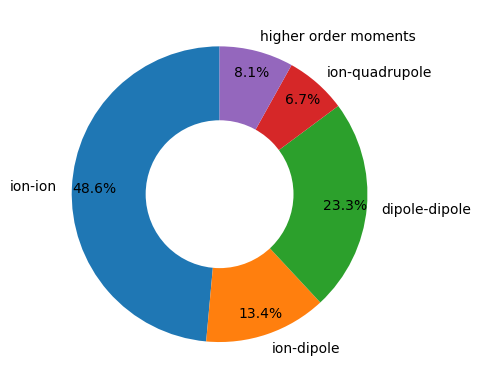

In [27]:
### Visualizing of the multipole moments
rmin = 23 # choose at which separation you want to plot

mp = {"exact": [], "sum of multipoles": [], "ion-ion": [], "ion-dipole": [], "dipole-dipole": [], "ion-quadrupole": []}

R, exact, tot, ii, id, dd, iq, mucorr = np.loadtxt('multipole.dat', unpack=True, skiprows=2)
mask = (R == rmin)
mp['exact'].append( exact[mask] )
mp['sum of multipoles'].append( tot[mask] )
mp['ion-ion'].append( ii[mask] )
mp['ion-dipole'].append( id[mask] )
mp['dipole-dipole'].append( dd[mask] )
mp['ion-quadrupole'].append( iq[mask] )

exact = mp['exact'][0][0]
contributions = {}
sum_of_multipoles = 0
for name, energies in mp.items():
    if name == 'exact' or name == 'sum of multipoles':
        continue
    percentage = energies[0][0] / exact * 100
    contributions[name] = np.abs(percentage)
    sum_of_multipoles += percentage

contributions['higher order moments'] = np.abs(100 - sum_of_multipoles)
explode = [0, 0, 0, 0, 0.1]
plt.pie(contributions.values(), labels=contributions.keys(), autopct='%1.1f%%', pctdistance=0.85, startangle=90)
centre_circle = plt.Circle((0,0), 0.5, fc='white')  
plt.gca().add_artist(centre_circle)
plt.savefig("multipole_donut.pdf", bbox_inches='tight')
plt.show()

In [43]:
### Load topology and trajectory
u = mda.Universe("confout.xyz", "traj.xtc")

### Show interactive visualization
view = nv.show_mdanalysis(u)
view.add_unitcell()

# Increase the display size
view._remote_call("setSize", target="Widget", args=["800px", "600px"])  # Width x Height
view

NGLWidget(max_frame=4999)

## Duello - fast calculation of protein interactions

Duello can calculate the potential of mean force (PMF) between two rigid bodies (example protein). This is done by performing a statistical mechanical average over inter-molecular orientations using subdivided icosahedrons. For each mass center separation, R, the static contribution to the partition function is explicitly evaluated to obtain the potential of mean force and the thermally averaged energy. From this the the osmotic second virial coefficient, $B_2$ and for systems with net attractive interactions, the dissociation constant, $K_d$ , can be estimated.
More information see: github/mlund/duello (tba)



In [32]:
### Change the following variables to match your system
%cd $workdir

xyz_file = "structures/2hiu_duello.xyz"     # The name of the xyz file
name = "2hiu"                               # What you want to call the output files 
molarity = "0.1"                            # The molarity of the ionic strength in the system
temp = "298"                                # The temperature of the system

resolution = "1.0"                          # The resolution of the PMF - smaller resolution higher accuracy -> longer runtime
rmin = "5"                                  # The minimum distance for the PMF - depends on the protein size
rmax = "55"                                 # The maximum distance for the PMF - depends on the protein size
dr = "1.0"                                  # The distance between each bin in the PMF - smaller dr higher accuracy -> longer runtime

/Users/isabelvinterbladh/Documents/YRI-Talk/YRI-Protein-Simulation


In [34]:
### Command for the duello scan calculation
command = f"/Users/isabelvinterbladh/Documents/YRI-Talk/rust/duello/target/release/duello scan \
--mol1 {xyz_file} \
--mol2 {xyz_file} \
--rmin {rmin} --rmax {rmax} --dr {dr} \
--top topology.yaml \
--resolution {resolution} \
--molarity {molarity} \
--temperature {temp} \
--pmf {name}-pmf.dat"

### Run the command using subprocess
result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

### Print the output and error (if any)
#print(result.stdout.decode())
print(result.stderr.decode())

print("done.")

 INFO  duello::energy > Adding Coulomb potential to nonbonded matrix
 INFO  duello         > Medium: 𝑇 = 298.00 K, εᵣ = 78.4, λᴮ = 7.2 Å, 𝐼 = 100.0 mM, λᴰ = 9.6 Å, 0.1 M 🧂Salt = NaCl
 INFO  duello         > Molecular net-charges:    [-2.00e, -2.00e]
 INFO  duello         > Molecular masses (g/mol): [5777.63e, 5777.63e]
 INFO  duello         > COM range: [5.0, 55.0) in 1.0 Å steps 🐾
 INFO  duello::icotable > Actual angle resolution = 0.55 radians
 INFO  duello::icoscan  > 6D table: 𝑅(50) x 𝜔(12) x 𝜃𝜑(42) x 𝜃𝜑(42) = 1058400 poses 💃🕺 (0.9 MB)
 INFO  duello::report   > Second virial coefficient, 𝐵₂ = -1911.18 Å³
 INFO  duello::report   >                               = -3.45e-5 mol⋅ml/g²
 INFO  duello::report   > Reduced second virial coefficient, 𝐵₂ / 𝐵₂hs = -0.22 using σ = 16.00 Å
 INFO  duello::report   > Dissociation constant, 𝐾𝑑 = 7.91e-2 mol/l using σ = 16.00 Å
 INFO  duello::report   > Plot: free energy and mean energy along mass center separation. In units of kT and angstroms.

don

In [36]:
### Command to extract values from the duello output

def extract(json_file):
    """ Extracting values from the duello output in a json file
    Args:
        jsom_file (str): The name of the json file
    Returns:
        pd.DataFrame: A pandas dataframe with the extracted values
    """
    db = dict(B2 = [], B2_HS = [], B2_red = [], kD = [])    
    with open(json_file, "r") as file:
        data = json.load(file)
        b2 = data["B2"]
        db["B2"].append(b2)
        b2_hs = data["B2_hs"]
        db["B2_HS"].append(b2_hs)
        b2_reduced = data["B2_reduced"]
        db["B2_red"].append(b2_reduced)
        if "kD" in data:
            db["kD"].append(data["kD"] * 1000)
        else:
            db["kD"].append(float('nan'))
    return pd.DataFrame(db).rename(columns={"kD": "𝐾𝑑/mM", "B2_red": "𝐵₂/𝐵₂hs", "B2_HS": "𝐵₂hs", "B2": "𝐵₂"})

            𝐵₂         𝐵₂hs   𝐵₂/𝐵₂hs      𝐾𝑑/mM
0 -1911.181275  8578.642339 -0.222784  79.149999


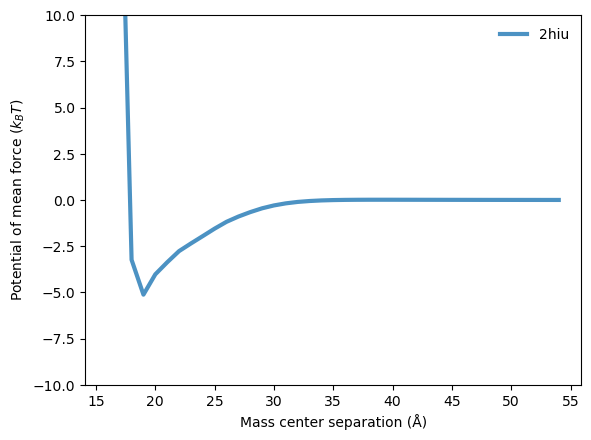

In [40]:
### Extract values from the duello output
print(extract(f"{name}-pmf.json"))

### Plotting the PMF - Potential of mean force

r, w, u, c = np.loadtxt(f"{name}-pmf.dat", unpack=True)
plt.plot(r, u, label=f'{name}', lw=3, alpha=0.8)
plt.legend(loc=0, frameon=False)

plt.ylim(-10, 10)
plt.xlabel("Mass center separation (Å)")
plt.ylabel("Potential of mean force ($k_BT$)")
plt.show()